In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from model import *
import torch
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from utils import *
from mmd import *
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## True posterior 

The first row in the plots is four samples in the noisy space $x' \sim x'|x$, together with the density p(x'|x).

We assume these points were sampled by first sampling a mixture component
then sampling the Gaussian to produce x then adding noise.

The posterior quantifies our belief in the location of x given the location
of the noised point.

Note that in the first three cases, because the x' points are low density we basically
conclude that we must have sampled a fairly low density x - hence the 'contracted'
appearance of the posterior distribution, which has been pulled towards the observation.

> Fortunately, given a noisy sample x' and an evaluation point x, we can evaluate the true density
  p(x|x') using Bayes rule: $p(x|x') = \frac{p(x'|x)p(x)}{p(x')}$
 Figure 1 shows the true posteriors given four different x′ where we use grid data in x-space to
 visualize the density.

The second row in the plots is

In [2]:
NOISE_LEVEL = 0.6

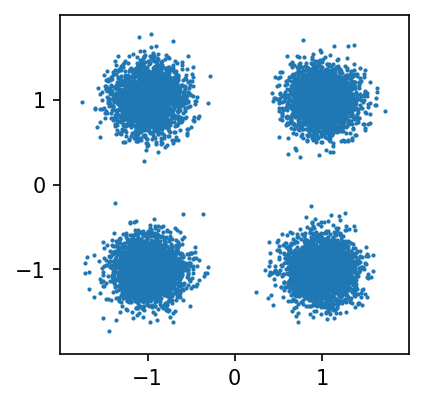

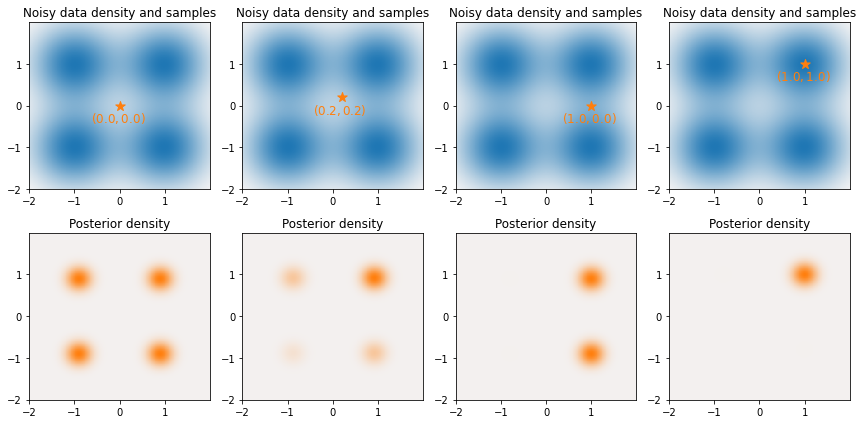

In [3]:
palette = sns.color_palette()

gmm_std=0.2
gmm=MoG4(std=gmm_std)

noise_std=NOISE_LEVEL
t_gmm_std=np.sqrt((noise_std**2+gmm_std**2))
t_gmm=MoG4(std=t_gmm_std)


def log_ptx_x(tx,x):
    """Probability of noisy data given clean data X=x."""
    return Normal(x,torch.ones_like(x)*noise_std).log_prob(tx).sum(-1)

def log_px_tx(x,tx):
    """Posterior probability of clean data given noisy data X'=tx, using Bayes rule.
    
    p(x|x'=tx) = p(x'=tx|x)p(x)/p(x'=tx)
    """
    return log_ptx_x(tx,x)+gmm.log_prob(x)-t_gmm.log_prob(tx)

X,Y=get_mesh()
# density of p(x) (GMM)
p_true_data=mesh_to_density(X,Y,lambda x:torch.exp(gmm.log_prob(x)))
# density of noisy p(x') (also a GMM)
p_noisy_data=mesh_to_density(X,Y,lambda x:torch.exp(t_gmm.log_prob(x)))


test_points=[torch.tensor([0.,0.]), torch.tensor([0.2,0.2]), torch.tensor([1.,0.]), torch.tensor([1.,1.])]
p_true_list=[mesh_to_density(X,Y,lambda x:torch.exp(log_px_tx(x,tx))) for tx in test_points]

dataset=torch.Tensor(gmm.sample([10000])).float()
get_plt()
plt.scatter(*dataset.T, alpha=1., color=palette[0], s=1);


def plot_pos(x, p, num=1, ax1=None, ax2=None):
    ax1.set_title("Noisy data density and samples")
    ax1.pcolormesh(X, Y, p_noisy_data.reshape(X.shape[0],Y.shape[0]), alpha=1.0,cmap=sns.light_palette(palette[0],as_cmap=True))
    ax1.scatter(x[0],x[1],marker='*',color=palette[1],s=100)
    ax1.text(x[0]-0.64, x[1]-0.4, r'$('+str(x[0])+','+str(x[1])+')$', fontdict=get_font(palette[1]))
    ax2.set_title("Posterior density")
    ax2.pcolormesh(X, Y, p.reshape(X.shape[0],Y.shape[0]), alpha=1.0,cmap=sns.light_palette(palette[1],as_cmap=True))

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for num, point in enumerate(test_points):
    plot_pos(point.numpy(), p_true_list[num].numpy(),num+1, ax1=axes[0, num], ax2=axes[1, num])
plt.tight_layout()
plt.show()

# Denoising score matching to learn the mean

In [4]:
opt={
    'epochs':100,
    'batch_size':100,
    'test_batch_size':100,
    'gibbs_steps':10000,
    'device':'cpu',
    'noise_std': NOISE_LEVEL,
    'x_dim':2,
    'layer_num':3,
    'lr':1e-4,
    'act':'swish',
    'seed':0,
}

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.65it/s]


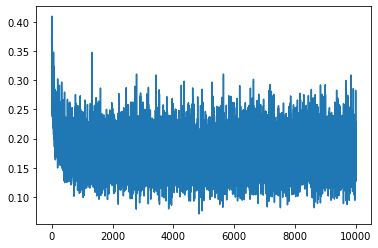

In [5]:
np.random.seed(opt['seed'])
torch.manual_seed(opt['seed'])

model2=DenoisingEBM(opt)
loss_list=[]
model2.train()
iterations=int(dataset.size()[0]/opt['batch_size'])
for t in tqdm(range(0,opt['epochs'])):
    for _ in range(0,iterations):
        model2.optimizer.zero_grad()
        indices = np.random.choice(dataset.size()[0],opt['batch_size'])
        batch_x = dataset[indices].to(opt['device'])
        noisy_x=(batch_x+torch.randn_like(batch_x)*opt['noise_std'])
        denoised_x_mean=model2(noisy_x)
        loss= torch.mean((batch_x-denoised_x_mean)**2)
        loss.backward()
        model2.optimizer.step()
        loss_list.append(loss.item())
plt.plot(loss_list)
plt.show()


We now have a trained EBM. We want to ask whether the learned energy correlates well with

  1. The true log probability log p(x)
  2. The noisy log probability log p(x') (which is what the model is actually approximating).

In the MoG case, the true energy conditioned on a mixture component is
$\tfrac{1}{2\sigma^2}\sum_i (x_i - \mu))$ and the noisy energy is $\tfrac{1}{2\sigma'^2}\sum_i (x_i - \mu)$
so, at least *within* mixture components the energies are clearly linearly related.

In high-density cases, one component will dominate and the linear relationship will be preserved

We also want to ask how the correlation varies across different noise levels, and how it is
affected by 

      i. learning a single model averaged across multiple energy levels, as in DSMBind,  
     ii. applying a 'clean energy' correction.

In [6]:
model2.eval()

def energy(x):
    with torch.no_grad():
        E = model2.net(x.float()).sum(-1)
    return -E

In [7]:
test_dataset = torch.Tensor(gmm.sample([10000])).float()
log_px = gmm.log_prob(test_dataset)
log_ptx = t_gmm.log_prob(test_dataset)
test_E = energy(test_dataset)

## Correlation between distribution densitites on points sampled from the data distribution

Text(0, 0.5, 'Energy')

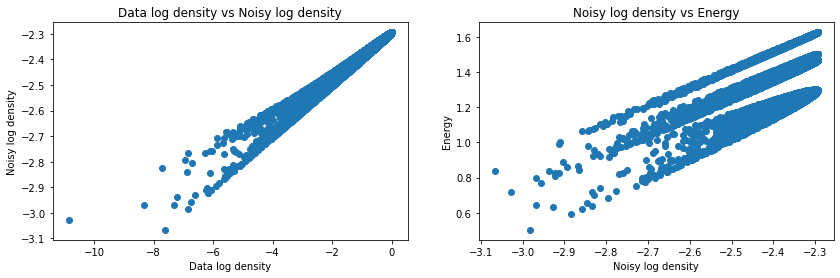

In [8]:
plt.figure(figsize=(14,4))
ax1 = plt.subplot(121)
ax1.scatter(log_px, log_ptx)
ax1.set_title("Data log density vs Noisy log density")
ax1.set_xlabel("Data log density")
ax1.set_ylabel("Noisy log density")

ax2 = plt.subplot(122)
ax2.set_title("Noisy log density vs Energy")
ax2.scatter(log_ptx, test_E)
ax2.set_xlabel("Noisy log density")
ax2.set_ylabel("Energy")

## Correlation between distribution densitites on grid points

Disagreement for mog mainly occurs in low-probability regions.

### 1. Noisy vs data distribution

In [9]:
X,Y=get_mesh()
mesh_data=torch.from_numpy(np.concatenate((X.reshape(-1,1),Y.reshape(-1,1)),1))
mesh_data.shape
# density of p(x) (GMM)
logp_true_mesh=gmm.log_prob(mesh_data)
# density of noisy p(x') (also a GMM)
logp_noisy_mesh=t_gmm.log_prob(mesh_data)

In [10]:
pearsonr(logp_true_mesh, logp_noisy_mesh)

PearsonRResult(statistic=0.9187118102765903, pvalue=0.0)

Text(0, 0.5, 'Noisy density')

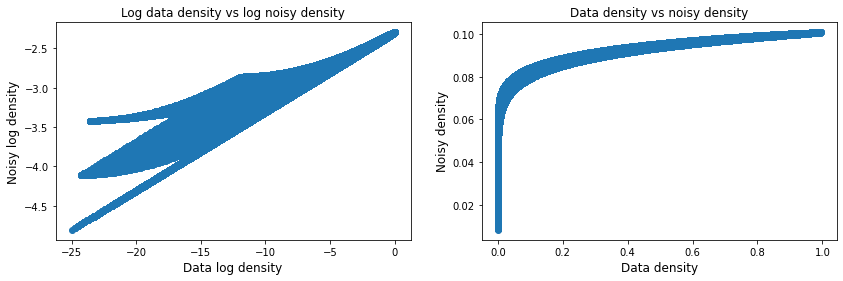

In [11]:
fig = plt.figure(figsize=(14,4))

ax1 = plt.subplot(121)
plt.scatter(logp_true_mesh, logp_noisy_mesh)
ax1.set_xlabel("Data log density", fontsize=12)
ax1.set_ylabel("Noisy log density", fontsize=12)
ax1.set_title("Log data density vs log noisy density")
ax2 = plt.subplot(122)
plt.scatter(torch.exp(logp_true_mesh), torch.exp(logp_noisy_mesh))
ax2.set_title("Data density vs noisy density")
ax2.set_xlabel("Data density", fontsize=12)
ax2.set_ylabel("Noisy density", fontsize=12)

### 2. Learned energy vs data/noise distributions

**TODO: check whether I should be summing the final dimension... unclear**

In [12]:
energy_mesh = energy(mesh_data)

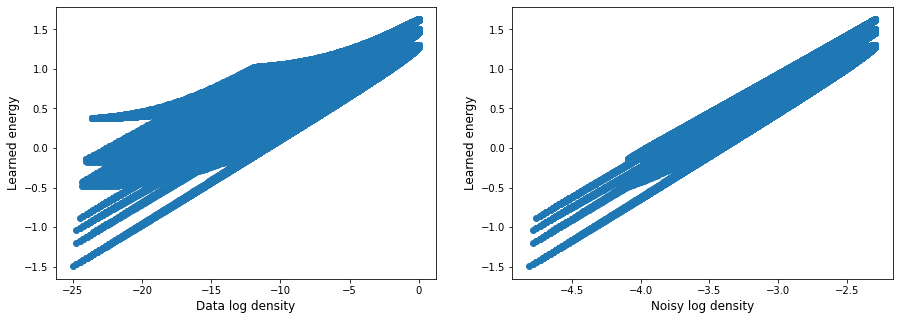

In [13]:
fig = plt.figure(figsize=(15,5))

ax1 = plt.subplot(121)
plt.scatter(logp_true_mesh, energy_mesh)
# ax1.set_title("")
ax1.set_xlabel("Data log density", fontsize=12)
ax1.set_ylabel("Learned energy", fontsize=12)
ax2 = plt.subplot(122)
ax2.set_xlabel("Noisy log density", fontsize=12)
ax2.set_ylabel("Learned energy", fontsize=12)
plt.scatter(logp_noisy_mesh, energy_mesh)

## Estimating the data density given the learned energy and posterior approximation


### Importance sampling

$\text{log} p(x) = \text{log} \int p(x|x')p(x') dx'$
$\text{log} p(x) = \text{log} \int \frac{p(x|x')p(x')}{p(x'|x)} p(x'|x) dx'$
$\text{log} p(x) \approx \text{log} \frac{1}{N}\sum_i \frac{p(x|x'_i)p(x'_i)}{p(x'|x)}\:, x'_i \sim p(x'|x)$ 

TODO: check that we're ok not normalising weights - equivalent to subtracting a constant?

maybe compute with a log sum exp

N.B. this is probably equivalent to the old version below when $p(x|x')$ is known exactly.

### Old version
Now we see whether a correction allows us to accurately compute / correct the density $p(x)$

$\text{log} p(x) = \int \text{log}\frac{p(x|x')p(x')}{p(x'|x)} p(x'|x) dx' = \text{log}\int\frac{p(x|x')p(x')}{p(x'|x)} p(x'|x) dx'$

$\text{log} p(x) \approx \frac{1}{N}\sum_i \text{log}\frac{p(x|x'_i)p(x'_i)}{p(x'_i|x)}$

N.B. we don't know the normalisation constant of p(x') - what effect does this have? maybe just a constant offset?

In [14]:
# TODO: we should batch these computations
from torch.distributions import Independent, Normal


def clean_energy_is(x, log_posterior, log_noisy_x, num_samples=300):
    # suppose x is b, 2
    # then we need a bunch of normal distributions
    # the final dimension is interpreted as a non-batch dimension by Independent
    noise_dist = Independent(Normal(x, torch.ones_like(x)*NOISE_LEVEL), reinterpreted_batch_ndims=1)
    b = x.shape[0]
    x_noisy = noise_dist.sample((num_samples,))  # 100, b, 2
    x_noisy_flat = x_noisy.reshape(num_samples*b, 2)
    x_tiled = x.expand(num_samples, -1,-1).reshape(num_samples*b,2)

    log_integrand = log_posterior(x_tiled, x_noisy_flat).reshape(num_samples,b) + log_noisy_x(x_noisy_flat).reshape(num_samples,b) - noise_dist.log_prob(x_noisy)
    # now do log sum exp to compute average
    s = torch.logsumexp(log_integrand - torch.log(torch.tensor(num_samples).float()), 0)
    return s


def clean_energy_v0(x, log_posterior, log_noisy_x, num_samples=500):
    # suppose x is b, 2
    # then we need a bunch of normal distributions
    # the final dimension is interpreted as a non-batch dimension by Independent
    noise_dist = Independent(Normal(x, torch.ones_like(x)*NOISE_LEVEL), reinterpreted_batch_ndims=1)
    b = x.shape[0]
    x_noisy = noise_dist.sample((num_samples,))  # 100, b, 2
    x_noisy_flat = x_noisy.reshape(num_samples*b, 2)
    x_tiled = x.expand(num_samples, -1,-1).reshape(num_samples*b,2)

    # n.b. because noise_dist is in fact a batch of dists, input shape is different
    log_px = log_posterior(x_tiled, x_noisy_flat).reshape(num_samples,b) + log_noisy_x(x_noisy_flat).reshape(num_samples,b) - noise_dist.log_prob(x_noisy)
    # average over the samples
    return log_px.mean(0)
    

### 1. Using the true posterior p(x|x') and the learned noisy energy E(x')

In [15]:
# note in this toy example, because p(x) is known, we can compute log_posterior.
# but in general, we will need to approximate.
clean_E = clean_energy_v0(test_dataset, log_px_tx, energy)
clean_E_is = clean_energy_is(test_dataset, log_px_tx, energy)

Something a bit weird is happening here: we don't actually have a particularly good approximation
to the noisy density but it doesn't matter when we look at the clean density as long as our posterior
is accurate - noise in p(x') averaging out?

PearsonRResult(statistic=0.9936395017991693, pvalue=0.0)
PearsonRResult(statistic=0.9938770126388433, pvalue=0.0)


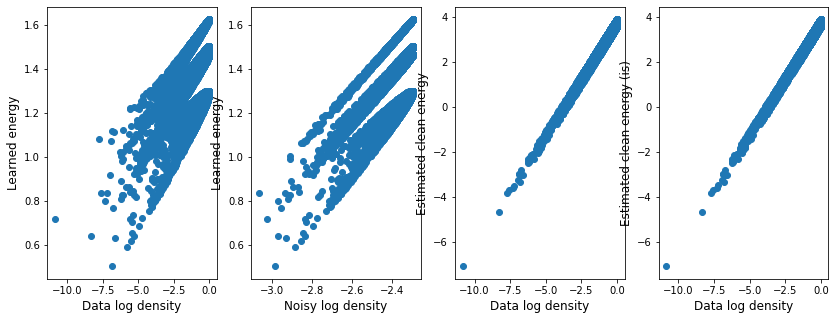

In [16]:
fig = plt.figure(figsize=(14,5))

ax1 = plt.subplot(141)
ax1.set_xlabel("Data log density", fontsize=12)
ax1.set_ylabel("Learned energy", fontsize=12)
plt.scatter(log_px, test_E)

ax2 = plt.subplot(142)
ax2.set_xlabel("Noisy log density", fontsize=12)
ax2.set_ylabel("Learned energy", fontsize=12)
plt.scatter(log_ptx, test_E)

ax3 = plt.subplot(143)
ax3.set_xlabel("Data log density", fontsize=12)
ax3.set_ylabel("Estimated clean energy", fontsize=12)
plt.scatter(log_px, clean_E)
print(pearsonr(log_px, clean_E))


ax4 = plt.subplot(144)
ax4.set_xlabel("Data log density", fontsize=12)
ax4.set_ylabel("Estimated clean energy (is)", fontsize=12)
plt.scatter(log_px, clean_E_is)
print(pearsonr(log_px, clean_E_is))

### 2. Using the approximated posterior q(x|x') and the learned noisy energy E(x')

There are two functions to approximate the posterior: 

**TODO: check shapes**

```
model2.logp_x_tx_isotropic_cov(x,x')
model2.logp_x_tx_full_cov(x,x')

```

TODO: consider batching these if we run into memory issues

In [17]:
test_dataset.shape

torch.Size([10000, 2])

In [23]:
print('Estimated isotropic variance:', model2.isotropic_cov_estimation(test_dataset[:1000]).item())
clean_E_isotropic_cov = clean_energy_v0(test_dataset[:1000], model2.logp_x_tx_isotropic_cov, energy)
clean_E_isotropic_cov_is = clean_energy_is(test_dataset[:1000], model2.logp_x_tx_isotropic_cov, energy)

Estimated isotropic variance: 0.15855112671852112


In [24]:
clean_E_full_cov = clean_energy_v0(test_dataset[:1000], model2.logp_x_tx_full_cov, energy)
clean_E_full_cov_is = clean_energy_is(test_dataset[:1000], model2.logp_x_tx_full_cov, energy)

PearsonRResult(statistic=0.7755135065637955, pvalue=1.4756160170498754e-201)
PearsonRResult(statistic=0.9160579236732644, pvalue=0.0)
PearsonRResult(statistic=0.9940415788619714, pvalue=0.0)
PearsonRResult(statistic=0.6152077261706091, pvalue=3.519188702267738e-105)


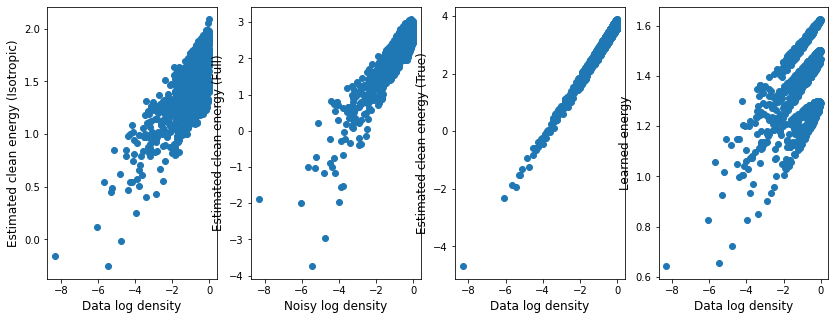

In [25]:
fig = plt.figure(figsize=(14,5))

ax1 = plt.subplot(141)
ax1.set_xlabel("Data log density", fontsize=12)
ax1.set_ylabel("Estimated clean energy (Isotropic)", fontsize=12)
plt.scatter(log_px[:1000], clean_E_isotropic_cov)
print(pearsonr(log_px[:1000], clean_E_isotropic_cov))

ax2 = plt.subplot(142)
ax2.set_xlabel("Noisy log density", fontsize=12)
ax2.set_ylabel("Estimated clean energy (Full)", fontsize=12)
plt.scatter(log_px[:1000], clean_E_full_cov)
print(pearsonr(log_px[:1000], clean_E_full_cov))

ax3 = plt.subplot(143)
ax3.set_xlabel("Data log density", fontsize=12)
ax3.set_ylabel("Estimated clean energy (True)", fontsize=12)
plt.scatter(log_px[:1000], clean_E[:1000])
print(pearsonr(log_px[:1000], clean_E[:1000]))

ax3 = plt.subplot(144)
ax3.set_xlabel("Data log density", fontsize=12)
ax3.set_ylabel("Learned energy", fontsize=12)
plt.scatter(log_px[:1000], test_E[:1000])
print(pearsonr(log_px[:1000], test_E[:1000]))

PearsonRResult(statistic=0.744498326855496, pvalue=2.5890609610636803e-177)
PearsonRResult(statistic=0.9270644447088212, pvalue=0.0)
PearsonRResult(statistic=0.9940415788619714, pvalue=0.0)
PearsonRResult(statistic=0.6152077261706091, pvalue=3.519188702267738e-105)


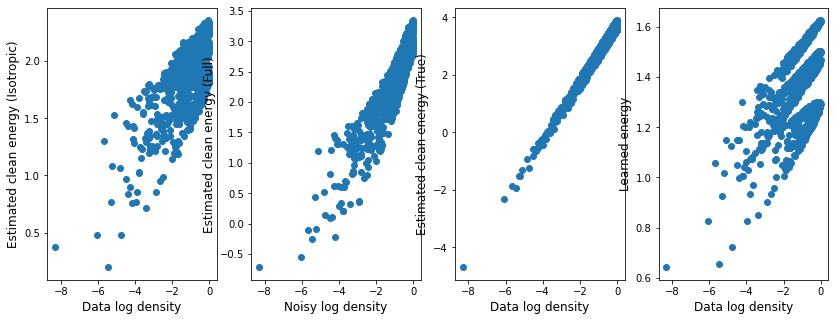

In [26]:
fig = plt.figure(figsize=(14,5))

ax1 = plt.subplot(141)
ax1.set_xlabel("Data log density", fontsize=12)
ax1.set_ylabel("Estimated clean energy (Isotropic)", fontsize=12)
plt.scatter(log_px[:1000], clean_E_isotropic_cov_is)
print(pearsonr(log_px[:1000], clean_E_isotropic_cov_is))

ax2 = plt.subplot(142)
ax2.set_xlabel("Noisy log density", fontsize=12)
ax2.set_ylabel("Estimated clean energy (Full)", fontsize=12)
plt.scatter(log_px[:1000], clean_E_full_cov_is)
print(pearsonr(log_px[:1000], clean_E_full_cov_is))

ax3 = plt.subplot(143)
ax3.set_xlabel("Data log density", fontsize=12)
ax3.set_ylabel("Estimated clean energy (True)", fontsize=12)
plt.scatter(log_px[:1000], clean_E[:1000])
print(pearsonr(log_px[:1000], clean_E[:1000]))

ax3 = plt.subplot(144)
ax3.set_xlabel("Data log density", fontsize=12)
ax3.set_ylabel("Learned energy", fontsize=12)
plt.scatter(log_px[:1000], test_E[:1000])
print(pearsonr(log_px[:1000], test_E[:1000]))

### 3. Using the true posterior p(x|x') and the true density of the noisy data p(x')

(Above we used the true posterior and the estimated density of the noisy data)

In [28]:
# note in this toy example, because p(x) is known, we can compute log_posterior.
# but in general, we will need to approximate.
clean_E_gt = clean_energy_v0(test_dataset, log_px_tx, t_gmm.log_prob)

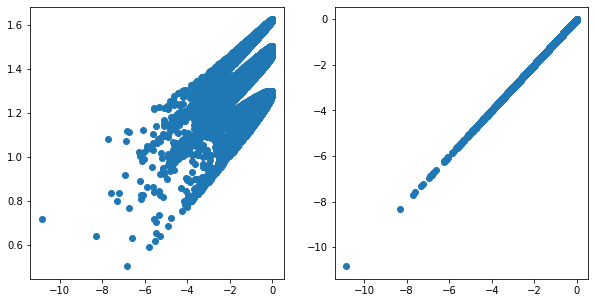

In [30]:
fig = plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
plt.scatter(log_px, test_E)
ax2 = plt.subplot(122)
plt.scatter(log_px, clean_E_gt)

## Using noise contrastive estimation to learn a better posterior approximation

n.b. to use isotropic version we first need to estimate isotropic variance

In [31]:
from nce import NCEDenoisingClassifier

In [32]:
print('Estimated isotropic variance:', model2.isotropic_cov_estimation(dataset[:1000]).item())

Estimated isotropic variance: 0.17998631298542023


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


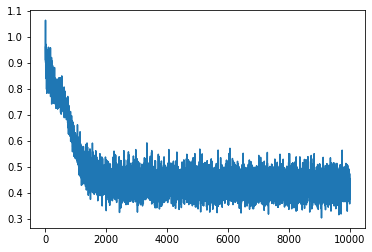

In [33]:

np.random.seed(opt['seed'])
torch.manual_seed(opt['seed'])

nce_model = NCEDenoisingClassifier(opt)
model2.eval()

loss_list=[]
iterations=int(dataset.size()[0]/opt['batch_size'])
for t in tqdm(range(0,opt['epochs'])):
    for _ in range(0,iterations):
        nce_model.optimizer.zero_grad()
        indices = np.random.choice(dataset.size()[0],opt['batch_size'])
        batch_x = dataset[indices].to(opt['device'])
        noisy_x=(batch_x+torch.randn_like(batch_x)*opt['noise_std'])
        
        # N.B. it would actually be better to compute the distribution
        # and then sample / log prob because otherwise recomputing the distribution is expensive
        # with full cov i got non-positive definite covariance issue
        q_x_dist = model2.dist_p_x_tx_isotropic_cov(noisy_x)
        q_x_sample = q_x_dist.sample()  # the 'noise distribution for nce'. can we get log probs without recomputing?

        # conditioning variable is always noisy_x; prediction variables are q_x_sample and batch_x
        inputs = torch.cat([q_x_sample, batch_x], axis=0)  # shape (batch_size*2, x_dim)
        noisy_x_repeated = torch.cat([noisy_x, noisy_x], axis=0)  # shape (batch_size*2, x_dim)
        nce_energy = nce_model(inputs, noisy_x_repeated)  # shape (batch_size*2,)
        
        noise_log_q = q_x_dist.log_prob(q_x_sample)
        data_log_q = q_x_dist.log_prob(batch_x)
        
        logit = nce_energy - torch.cat((noise_log_q, data_log_q), axis=0)
        targets = torch.cat([torch.zeros(opt['batch_size']), torch.ones(opt['batch_size'])], axis=0).to(opt['device'])

        loss = F.binary_cross_entropy_with_logits(logit, targets).mean()

        loss.backward()
        nce_model.optimizer.step()
        loss_list.append(loss.item())

plt.plot(loss_list)
plt.show()

In [34]:
# note in this toy example, because p(x) is known, we can compute log_posterior.
# but in general, we will need to approximate.
nce_model.eval()
with torch.no_grad():
    clean_E_nce = clean_energy_v0(test_dataset, nce_model, t_gmm.log_prob)
    
with torch.no_grad():
    clean_E_nce_is = clean_energy_is(test_dataset, nce_model, t_gmm.log_prob)

PearsonRResult(statistic=0.6152077261706091, pvalue=3.519188702267738e-105)
PearsonRResult(statistic=0.9878376008223286, pvalue=0.0)
PearsonRResult(statistic=0.9876435901555816, pvalue=0.0)


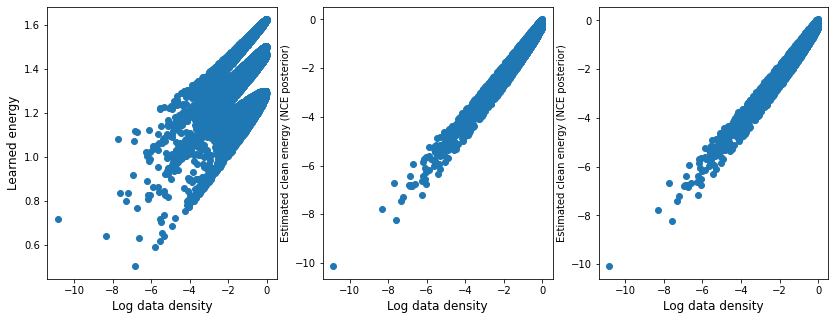

In [35]:
# just compute pearson on first 1000 points for consistency with above.

fig = plt.figure(figsize=(14,5))

ax1 = plt.subplot(131)
ax1.set_xlabel("Log data density", fontsize=12)
ax1.set_ylabel("Learned energy", fontsize=12)
plt.scatter(log_px, test_E)
print(pearsonr(log_px[:1000], test_E[:1000]))

ax2 = plt.subplot(132)
ax2.set_xlabel("Log data density", fontsize=12)
ax2.set_ylabel("Estimated clean energy (NCE posterior)")
# Question: why does clean_E_nce require grad? might just be that it's not wrapped in any no grad
plt.scatter(log_px, clean_E_nce.detach().cpu().numpy())
print(pearsonr(log_px[:1000], clean_E_nce[:1000].detach().cpu().numpy()))

ax3 = plt.subplot(133)
ax3.set_xlabel("Log data density", fontsize=12)
ax3.set_ylabel("Estimated clean energy (NCE posterior)")
# Question: why does clean_E_nce require grad? might just be that it's not wrapped in any no grad
plt.scatter(log_px, clean_E_nce_is.detach().cpu().numpy())
print(pearsonr(log_px[:1000], clean_E_nce_is[:1000].detach().cpu().numpy()))